In [6]:
using JuMP, Plots, Ipopt #JuMP model, Ipopt solver

In [24]:
# specific parameters for each model 
P = 200 # number of points,
ΔP  = 25
N = 2   # number of trailers,
M = 2   # M number of constrained trailers,
μ = 1e-4 # smoothing constant 
ϵ = 1e-2 # current constant 

if N ≥ 2
    l = 1/ N # length of trailers
else
    l = 1/sqrt(N)
end

# initial data
x0 = 0 
y0 = 0 
c0 = 0
θ0 = pi/7

# final data
xf = 4
yf = 7
θf = π/2

param   = [x0 y0 θ0 xf yf θf];

In [25]:
x_step  = zeros(1)
y_step  = zeros(1)
θ_step  = zeros(1)
u_step  = zeros(1)
time    = zeros(1)
Δt_step = zeros(1)
β_step  = zeros(1,N)

x_step[1] = param[1]
y_step[1] = param[2]
θ_step[1] = param[3];

compteur = 0
accuracy = 0.1
while (xf - accuracy ≥ param[1] || xf + accuracy ≤ param[1]  )    &&   (yf - accuracy ≥ param[2] || yf + accuracy ≤ param[2] )
    
    is_current_constant = false 
    function water(x,y)  # function wich gives the current velocity according to the x position 
        if is_current_constant 
            wx = 0.8
            wy = 0
        else
            η = @NLexpression(sys,ϵ + sqrt((0.4-ϵ*y)^2 + ϵ^2*x^2))
            wx = @NLexpression(sys,(0.4-ϵ*y)/η)
            wy = @NLexpression(sys, ϵ*x/η)
        end
        return wx,wy
    end
    
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>1, "print_frequency_iter"=>1000))
    set_optimizer_attribute(sys, "tol", 1e-14)
    set_optimizer_attribute(sys, "max_iter", 1000)
    set_silent(sys)
    
    #JuMP model, Ipopt solver
    JuMP.@variables(sys,begin
        x[1:P]                          # x 
        y[1:P]                          # y 
        θ[1:P]                       # theta 
        -1≤u[1:P]≤1
        0≤ Δt ≤ 1
        c[1:P]
    end) 
    
    JuMP.@variable(sys, betas[1:P, 1:N])
    
    #Objective
    @objective(sys, Min, Δt+μ*c[P])
    
    #Constraints
    @constraints(sys,begin
        x[1] == param[1]
        y[1] == param[2]
        θ[1] == param[3]
        c[1] == c0
        x[P] == param[4]
        y[P] == param[5]
        θ[P] == param[6]
    end)
    
    # betas initialisation
    @constraint(sys, c1[j=1:N], betas[1,j]==β_step[1+ΔP*compteur,j])
    
    # constraints for betas(tf)
    if M != 0 
        @constraint(sys, c2[j=1:M], betas[P,j]==0) 
    end
    # constraints for betas
    ((@constraint(sys, -sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i) ≤ betas[j,i] ≤ sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i) ) for j in 1:P) for i in 1:N)
    
    # water dynamic : 
    wx = water(param[1],param[2])[1]
    wy = water(param[1],param[2])[2]
    for j in 1 : P-1
        @NLconstraint(sys, # x' = w + cos(theta)
            x[j+1] == x[j] + 0.5 * Δt * ( wx + cos(θ[j]) + wx + cos(θ[j+1])))
        @NLconstraint(sys, # y' = sin(theta) 
            y[j+1] == y[j] + 0.5* Δt *( wy +sin(θ[j])+ sin(θ[j+1])+ wy))
    
        if N ≥ 1  
           @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
                betas[j+1,1] == betas[j,1] + 0.5 * Δt * (-u[j]-(1/l)*sin(betas[j,1]) - u[j+1] - (1/l)*sin(betas[j+1,1]))) 
        end
        if N ≥ 2  
            @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
                betas[j+1,2] == betas[j,2] + 0.5 *  Δt * (-u[j] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[j+1] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
        end
        if N ≥ 3 
            for i in 3 : N 
              prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
              prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
              @NLconstraint(sys, #betas for i = 3 to N
                    betas[j+1,i] == betas[j,i]+ 0.5*Δt*(-u[j]-prod1/l -u[j+1] -prod2/l ) ) 
            end
        end        
    end
    
    @NLconstraint(sys,p_t[j = 1:(P-1)],  # theta ' = u 
            θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

    @NLconstraint(sys, c_[j = 1:(P-1)],  # L2-norm regularization on the control
            c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))

    #Solve for the control and state
    println("Solving..." , "\n")
    print("Optimisation  : ", compteur+1, "\n")
    print(param,"\n")
    status = optimize!(sys)
    println("Solver status : ",status)

    sys2 = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>1, "print_frequency_iter"=>1000))
    set_optimizer_attribute(sys2, "tol", 1e-14)
    set_optimizer_attribute(sys2, "max_iter", 1000)
    set_silent(sys2)

    is_current_constant_ = false 
    function water_(x,y)  # function wich gives the current velocity according to the x position 
        if is_current_constant_ 
            wx = 0.8
            wy = 0
        else
            η = @NLexpression(sys2,ϵ + sqrt((0.4-ϵ*y)^2 + ϵ^2*x^2))
            wx = @NLexpression(sys2,(0.4 - ϵ*y)/ η)
            wy = @NLexpression(sys2,ϵ*x / η)
        end
        return wx,wy
    end

    #Dynamics : Crank-Nicolson
    JuMP.@variables(sys2, begin
        x_[1:P]                       # x 
        y_[1:P]                       # y 
        θ_[1:P]                       # theta 
        c_[1:P]
        0≤ Δt_ ≤ 1
        end) 
    JuMP.@variable(sys2, betas_[1:P, 1:N])

    #Constraints
    @constraints(sys2, begin
        x_[1] == param[1]
        y_[1] == param[2]
        θ_[1] == param[3]
    end)
    
    # betas initialisation
    @constraint(sys2, c1[j=1:N], betas_[1,j]==β_step[1+ΔP*compteur,j])
    
    # constraints for betas(tf)
    if M != 0 
        @constraint(sys2, c2[j=1:M], betas_[P,j]==0) 
    end
    
    # control: 
    u_opt = value.(u)
    Δt_ = value.(Δt)
    
    # constraints for betas
    ((@constraint(sys2, -sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ≤betas_[j,i]≤sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ) for j in 1:P) for i in 1:N)
    
    for j in 1 : P-1
        @NLconstraint(sys2, # x' = w + cos(theta)
            x_[j+1] == x_[j] + 0.5 * Δt_ * ( water_(x_[j],y_[j])[1] + cos(θ_[j]) + water_(x_[j+1],y_[j+1])[1]  + cos(θ_[j+1])))
        @NLconstraint(sys2, # y' = sin(theta) 
            y_[j+1] == y_[j] + 0.5* Δt_ *( water_(x_[j],y_[j])[2] +sin(θ_[j])+ sin(θ_[j+1])+ water_(x_[j+1],y_[j+1])[2]))
    
        if N ≥ 1  
           @NLconstraint(sys2, #beta1 ' = -u- 1/l * sin(beta1)
                betas_[j+1,1] == betas_[j,1] + 0.5 * Δt_ * (-u_opt[j]-(1/l)*sin(betas_[j,1]) - u_opt[j+1] - (1/l)*sin(betas_[j+1,1]))) 
        end
        if N ≥ 2  
            @NLconstraint(sys2, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
                betas_[j+1,2] == betas_[j,2] + 0.5 *  Δt_ * (-u_opt[j] - cos(betas_[j,1])*sin(betas_[j,2] - betas_[j,1])/l - u_opt[j+1] - cos(betas_[j+1,1])*sin(betas_[j+1,2] - betas_[j+1,1])/l ))   
        end
        if N ≥ 3 
            for i in 3 : N 
              prod1 = @NLexpression(sys2,prod(cos(betas_[j,p]-betas_[j,p-1]) for p in 2 : i-1 )*sin(betas_[j,i]-betas_[j,i-1])*cos(betas_[j,1]) )
              prod2 = @NLexpression(sys2,prod(cos(betas_[j+1,p]-betas_[j+1,p-1]) for p in 2 : i-1 )*sin(betas_[j+1,i]-betas_[j+1,i-1])*cos(betas_[j+1,1]) )  
              @NLconstraint(sys2, #betas for i = 3 to N
                    betas_[j+1,i] == betas_[j,i]+ 0.5*Δt_*(-u_opt[j]-prod1/l -u_opt[j+1] -prod2/l ) ) 
            end
        end
    end
    
    @NLconstraint(sys2, p_t[j = 1:(P-1)],  # theta ' = u 
            θ_[j+1] == θ_[j] + 0.5 * Δt_ * (u_opt[j] + u_opt[j+1]) )

    println("Solving...","\n")

    status = optimize!(sys2)
    println("Solver status : ",status,"\n")
    println("Cost : " , objective_value(sys2),"\n")
    
    param[1] = value.(x_[ΔP])
    param[2] = value.(y_[ΔP])
    param[3] = value.(θ_[ΔP])    
   
    x_step = [x_step ; value.(x_[1:ΔP]) ]
    y_step = [y_step ; value.(y_[1:ΔP]) ]
    θ_step = [θ_step ; value.(θ_[1:ΔP]) ]
    β_step = [β_step ; value.(betas_[1:ΔP,:]) ]
    u_step = [u_step ; u_opt[1:ΔP] ]
    
    Δt_step = [Δt_step ; Δt_]
    time = [time ; Δt_*ΔP]
    
    compteur += 1 
end;

Solving...

Optimisation  : 1
[0.0 0.0 0.4487989505128276 4.0 7.0 1.5707963267948966]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6379
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13333

Total number of variables............................:     1401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1205
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha

In [27]:
x_step = x_step[2:end]
y_step = y_step[2:end]
θ_step = θ_step[2:end]
β_step = β_step[2:end,1:end]
time = time[2:end]
u_step = u_step[2:end]
Δt_step = Δt_step[2:end];

In [28]:
print("The final time for the simulation is : ", sum(time) )

The final time for the simulation is : 20.330072715679055

In [90]:
# compute the step time during all the simulations
t = zeros(1)
t = [t; (0 : ΔP-1)*Δt_step[1] ]
for i in 2 : compteur
    buffer = (0 : ΔP-1)*Δt_step[i-1] 
    s = 0
    for j in 1 : i-1
        s += time[j]
    end
    buffer = buffer + s*ones(ΔP)
    t = [t ; buffer]
end;

In [91]:
t = t[2:end-1];

In [100]:
#plot states : 
x_plot = plot(t, x_step, xlabel = "t", ylabel = "position x", legend = false)
y_plot = plot(t, y_step, xlabel = "t", ylabel = "position y", legend = false)
θ_plot = plot(t, θ_step, xlabel = "t", ylabel = "θ", legend = false)
u_plot = plot(t, u_step, xlabel = "t", ylabel = "control u ", legend = false)
display(plot(x_plot, y_plot, θ_plot, u_plot, layout = (2,2), size=(600, 600)))

In [104]:
for i in 1:N 
    name = "β" * string(i)
    display(plot(t, β_step[:,i], xlabel ="t", ylabel=name, legend =false, layout =(1,1), size=(400, 400)))
end

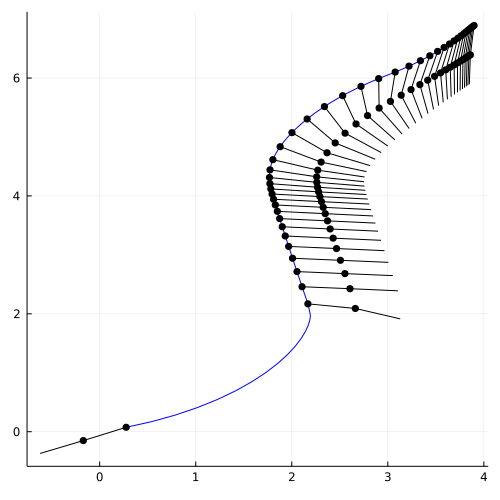

In [105]:
# plot trajectory 
p = plot(x_step, y_step, label = "trajectory", color=:blue, legend=:left)
plot!(size=(500,500))

for j in 1 : ΔP : size(x_step)[1]
    betas_z = zeros(2,N+1)
    betas_z[1,1] = x_step[j]
    betas_z[2,1] = y_step[j]
    θ_p = θ_step[j]
    
    β_v = zeros(N)
    θ_v = zeros(N)
    
    for i in 2 : N+1
        β_v[i-1]= β_step[j,i-1]
        θ_v[i-1] = β_v[i-1] + θ_p
        betas_z[1,i] = betas_z[1,i-1] - l*cos(θ_v[i-1])
        betas_z[2,i] = betas_z[2,i-1] - l*sin(θ_v[i-1])
        plot!([betas_z[1,i-1], betas_z[1,i]],[betas_z[2,i-1], betas_z[2,i]], color = :black,legend = false )
        plot!([betas_z[1,i-1]],[betas_z[2,i-1]],seriestype = :scatter,lw = 1,color = :black, legend = false)
        plot!(size=(500,500))
    end
end
current()